Shape of input_array: (480, 640, 3)


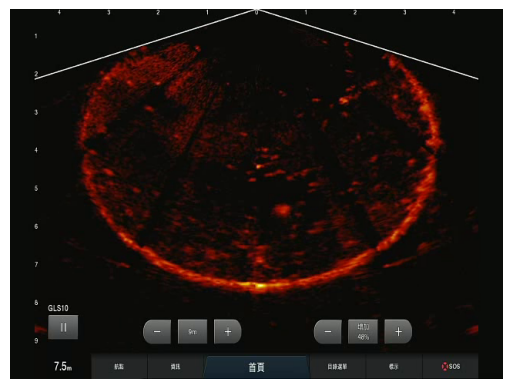

Shape of input_array: (480, 640, 3)
module 1: FME
Shape of input_image: (None, 480, 640, 3)
Shape of stage2_output: (None, 120, 160, 128)
Shape of stage3_output: (None, 60, 80, 256)
add FEM to stage3
Shape of adjusted_stage2_output: (None, 120, 160, 256)
Shape of stage3_fem_output: (None, 30, 40, 256)
Shape of stage4_output: (None, 15, 20, 512)
add FEM to stage4
Shape of adjusted_stage3_output: (None, 30, 40, 512)
Shape of stage4_fem_output: (None, 8, 10, 512)
Shape of enhanced_features: (None, 8, 10, 10)
SM
SAB
Shape of X: (None, 8, 10, 10)
Shape of X_permuted: (None, 10, 8, 10)
Shape of C: 10
Shape of H: 8
Shape of W: 10
C3
Shape of X: (None, 8, 10, 2)
SAM
Shape of Xc: (None, 8, 10, 2)
Shape of QT: (80, 0)
Shape of K: (0, 80)
Shape of V: (2, 80)
(80, 80)
Shape of attention_weights: (80, 80)
(2, 80)
Shape of weighted_V: (1, 8, 10, 2)
Shape of SA: (None, 8, 10, 2)
C3
C1
CAB
Shape of X: (None, 8, 10, 10)
Shape of X_permuted: (None, 10, 8, 10)
Shape of C: 10
Shape of H: 8
Shape of W: 10


 Lambda)                                                                                          
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (0, 80)              0           ['conv2d_13[1][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 8, 10, 2)     6           ['re_lu[0][0]']                  
                                                                                                  
 tf.linalg.matmul (TFOpLambda)  (80, 80)             0           ['tf.compat.v1.transpose_1[0][0]'
                                                                 , 'tf.reshape_1[0][0]']          
                                                                                                  
 tf.reshape_2 (TFOpLambda)      (2, 80)              0           ['conv2d_14[0][0]']              
          

 conv2d_27 (Conv2D)             (None, 16, 20, 128)  16512       ['re_lu_8[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 20, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_9 (ReLU)                 (None, 16, 20, 128)  0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 20, 128)  16512       ['re_lu_9[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 16, 20, 128)  512        ['conv2d_28[0][0]']              
 ormalizat

Total params: 96,909,371
Trainable params: 96,905,013
Non-trainable params: 4,358
__________________________________________________________________________________________________


In [1]:
# GPNet_20231211
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# module 1
# Feature Map Extractor
def FME(input_image):
    print('module 1: FME')
    print('Shape of input_image:', input_image.shape)
    
    # 10Conv +3FC +2FEM
    model = Sequential()

    # stage1
    model.add(layers.Conv2D(64, kernel_size=[3, 3], padding='same', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=[3, 3], padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))

    # stage2
    model.add(layers.Conv2D(128, kernel_size=[3, 3], padding='same', activation='relu'))
    model.add(layers.Conv2D(128, kernel_size=[3, 3], padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
    stage2_output = model(input_image)
    print('Shape of stage2_output:', stage2_output.shape)

    # stage3
    stage3 = Sequential()
    stage3.add(layers.Conv2D(256, kernel_size=[3, 3], padding='same', activation='relu'))
    stage3.add(layers.Conv2D(256, kernel_size=[3, 3], padding='same', activation='relu'))
    stage3.add(layers.Conv2D(256, kernel_size=[3, 3], padding='same', activation='relu'))
    stage3.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
    
    stage3_output = stage3(stage2_output)
    print('Shape of stage3_output:', stage3_output.shape)
    
    # add FEM to stage3
    print('add FEM to stage3')
    # Global depth-wise convolution for global context
    x = layers.DepthwiseConv2D(3, depth_multiplier=1, padding='same', activation='relu')(stage3_output)
    x = layers.AveragePooling2D()(x)
    # Gather operator
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    gather_weights = layers.Dense(1, activation='sigmoid')(x)
    # Excite operator
    excite_features = layers.Multiply()([stage3_output, gather_weights])
    # Add residual connection
    adjusted_stage2_output = layers.Conv2D(256, kernel_size=(1, 1), padding='same')(stage2_output)
    print('Shape of adjusted_stage2_output:', adjusted_stage2_output.shape)
    stage3_fem_output = layers.Add()([stage3_output, excite_features])
        
    stage3_fem_output = layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same')(stage3_fem_output)
    print('Shape of stage3_fem_output:', stage3_fem_output.shape)
        
    # stage4
    stage4 = Sequential()
    stage4.add(layers.Conv2D(512, kernel_size=[3, 3], padding='same', activation='relu'))
    stage4.add(layers.Conv2D(512, kernel_size=[3, 3], padding='same', activation='relu'))
    stage4.add(layers.Conv2D(512, kernel_size=[3, 3], padding='same', activation='relu'))
    stage4.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
        
    stage4_output = stage4(stage3_fem_output)
    print('Shape of stage4_output:', stage4_output.shape)
    
    # add FEM to stage4
    print('add FEM to stage4')
    # Global depth-wise convolution for global context
    x = layers.DepthwiseConv2D(3, depth_multiplier=1, padding='same', activation='relu')(stage4_output)
    x = layers.AveragePooling2D()(x)
    # Gather operator
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    gather_weights = layers.Dense(1, activation='sigmoid')(x)
    # Excite operator
    excite_features = layers.Multiply()([stage4_output, gather_weights])
    # Add residual connection
    adjusted_stage3_output = layers.Conv2D(512, kernel_size=(1, 1), padding='same')(stage3_fem_output)
    print('Shape of adjusted_stage3_output:', adjusted_stage3_output.shape)
    stage4_fem_output = layers.Add()([stage4_output, excite_features])
        
    stage4_fem_output = layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same')(stage4_fem_output)
    print('Shape of stage4_fem_output:', stage4_fem_output.shape)
    
    # Full Connected layer 
    stage5 = Sequential()
    stage5.add(layers.Dense(512, activation='relu'))
    stage5.add(layers.Dense(256, activation='relu'))
    stage5.add(layers.Dense(128, activation='relu'))
    stage5.add(layers.Dense(10, activation=None))
    
    enhanced_features = stage5(stage4_fem_output)
    
    return enhanced_features


# module 3
# Segmentation Module
# 
# C3 module: includes Convolution layer followed by Batch Normalization and ReLU activation
def Conv3BNReLU(x, filters):
    print('C3')
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x


# C1: 1x1 Convolution
def Conv1(x, filters):
    print('C1')
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


def SAB(X, filters=256):
    # Spatial Attention Branch
    # X: input feature map => (C, H, W)
    
    def SAM(Xc):
        # Spatial Attention Module
        print('SAM')
        
        # Xc: convolved feature map => (C/4, H, W)
        print("Shape of Xc:", Xc.shape)
        
        # step1: convolved first to produce matrices query Q(C/32, H, W), key K(C/32, H, W), value V(C/4, H, W)
        conv_layer = tf.keras.layers.Conv2D(max(1, C//32), kernel_size=(1, 1), padding='same', activation=None)
        Q = conv_layer(Xc)
        K = conv_layer(Xc)
        V_conv_layer = tf.keras.layers.Conv2D(C//4, kernel_size=(1, 1), padding='same', activation=None)
        V = V_conv_layer(Xc)
        
        # step2: reshape & transpose Q, K, V
        # query Q: (C/32, H, W) reshape & transpose to (H×W, C/32)
        Q = tf.reshape(Q, (C//32, H*W))
        QT = tf.transpose(Q)
        print("Shape of QT:", QT.shape)
        
        # key K: (C/32, H, W) reshape to (C/32, H×W)
        K = tf.reshape(K, (C//32, H*W))
        print("Shape of K:", K.shape)
        
        # value V: (C/4, H, W) reshape to (C/4, H×W)
        V = tf.reshape(V, (C//4, H*W))
        print("Shape of V:", V.shape)
        
        # step3: similarity matrix multiplication of Q^T and K and softmax to get attention_weights => (H×W, H×W) 
        dot_product_result = tf.matmul(QT, K)
        print(dot_product_result.shape) 
        # similarity_matrix = layers.dot(axes=[1, 1])([QT, K])
        attention_weights = layers.Activation('softmax')(dot_product_result)
        print("Shape of attention_weights:", attention_weights.shape)

        # step4: matrix multiplication of V and attention_weights => (C/4, H×W) and reshape to (C/4, H, W)
        weighted_V = tf.matmul(V, attention_weights)
        print(weighted_V.shape) 
        # weighted_V = layers.Dot(axes=[2, 1])([V, attention_weights])
        weighted_V = tf.reshape(weighted_V, (C//4, H, W))
        weighted_V = tf.expand_dims(weighted_V, axis=0)
        weighted_V = tf.transpose(weighted_V, perm=[0, 2, 3, 1])
        print("Shape of weighted_V:", weighted_V.shape)
        
        # SA: Add Xc to weighted_V => (C/4, H, W)
        SA = tf.keras.layers.Add()([weighted_V, Xc])
        print("Shape of SA:", SA.shape)
        
        return SA
    
    print('SAB')
    # X: input feature map => (C, H, W)
    print("Shape of X:", X.shape)
    X_permuted = tf.transpose(X, perm=[0, 3, 1, 2])
    print("Shape of X_permuted:", X_permuted.shape)
    B, C, H, W = X_permuted.shape
    print("Shape of C:", C)
    print("Shape of H:", H)
    print("Shape of W:", W)
    X = Conv3BNReLU(X, C//4)
    print("Shape of X:", X.shape)
    SA = SAM(X)
    spatial_attention = Conv3BNReLU(X * SA, filters)
    spatial_attention = Conv1(spatial_attention, 1)
    return spatial_attention


def CAB(X, filters=256):
    # Channel Attention Branch
    # X: input feature map => (C, H, W)
    
    def CAM(Xc):
        # Channel Attention Module
        print('CAM')
        
        # Xc: convolved feature map => (C/4, H, W)
        print("Shape of Xc:", Xc.shape)
        
        # step1: the matrices Q, K, and V are obtained from the Xc without convolution
        Q = Xc
        K = Xc
        V = Xc
        
        # step2: reshape & transpose Q, K, V
        # query Q: (C/4, H, W) reshape to (C/4, H×W)
        Q = tf.reshape(Q, (C//4, H*W))
        print("Shape of Q:", Q.shape)
        
        # key K: (C/4, H, W) reshape & transpose to (H×W, C/4)
        K = tf.reshape(K, (C//4, H*W))
        KT = tf.transpose(K)
        print("Shape of KT:", KT.shape)
        
        # value V: (C/4, H, W) reshape to (C/4, H×W)
        V = tf.reshape(V, (C//4, H*W))
        print("Shape of V:", V.shape)

        # step3: similarity matrix multiplication of Q and K^T and softmax to get attention_weights => (C/4, C/4) 
        dot_product_result = tf.matmul(Q, KT)
        print(dot_product_result.shape) 
        # similarity_matrix = layers.dot(axes=[1, 1])([Q, KT])
        attention_weights = layers.Activation('softmax')(dot_product_result)
        print("Shape of attention_weights:", attention_weights.shape)

        # step4: matrix multiplication of V and attention_weights => (C/4, H×W) and reshape to (C/4, H, W)
        # weighted_V = layers.Dot(axes=[2, 1])([attention_weights, V])
        # weighted_V = tf.reshape(weighted_V, (C//4, H, W))
        weighted_V = tf.matmul(attention_weights, V)
        print(weighted_V.shape) 
        weighted_V = tf.reshape(weighted_V, (C//4, H, W))
        weighted_V = tf.expand_dims(weighted_V, axis=0)
        weighted_V = tf.transpose(weighted_V, perm=[0, 2, 3, 1])
        print("Shape of weighted_V:", weighted_V.shape)
        
        # CA: Add Xc to weighted_V => (C/4, H, W)
        CA = tf.keras.layers.Add()([weighted_V, Xc])
        print("Shape of CA:", CA.shape)
        
        return CA
    
    print('CAB')
    # X: input feature map => (C, H, W)
    print("Shape of X:", X.shape)
    X_permuted = tf.transpose(X, perm=[0, 3, 1, 2])
    print("Shape of X_permuted:", X_permuted.shape)
    B, C, H, W = X_permuted.shape
    print("Shape of C:", C)
    print("Shape of H:", H)
    print("Shape of W:", W)
    X = Conv3BNReLU(X, C//4)
    print("Shape of X:", X.shape)
    CA = CAM(X)
    channel_attention = Conv3BNReLU(X * CA, filters)
    channel_attention = Conv1(channel_attention, 1)
    return channel_attention


def SM(input_features):
    print('SM')
    
    sa_output = SAB(input_features)
    
    ca_output = CAB(input_features)

    # Pixel-wise addition
    combined_output = tf.keras.layers.Add()([sa_output, ca_output])
    
    # Generate Attention Map
    attention_map = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(combined_output)
    
    attention_map = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(sa_output)

    return attention_map


# module 4
# Density Map Estimator
#
# Convolution Block in DME
def ConvBlockDME(input_features, filters, kernel_size):
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(input_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    return x

def DME(reweighted_features_map):
    print('module 4: DME')
    print('Shape of reweighted_features_map:', reweighted_features_map.shape)
    
    def Conv1x1(input_features, filters):
        return tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(input_features)

    # U: bilinear upsampling
    def Upsample(input_features):
        return tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(input_features)

    # Four convolution blocks
    B1 = ConvBlockDME(reweighted_features_map, 256, (1, 1))
    B1 = ConvBlockDME(B1, 256, (3, 3))
    B1 = Upsample(B1)

    B2 = ConvBlockDME(B1, 128, (1, 1))
    B2 = ConvBlockDME(B2, 128, (3, 3))
    B2 = Upsample(B2)

    B3 = ConvBlockDME(B2, 64, (1, 1))
    B3 = ConvBlockDME(B3, 64, (3, 3))
    B3 = Upsample(B3)

    B4 = ConvBlockDME(B3, 32, (1, 1))
    B4 = ConvBlockDME(B4, 32, (3, 3))

    density_map = Conv1x1(B4, 1)
    print('Shape of density_map:', density_map.shape)

    return density_map


def GPNet(input_layer):
    enhanced_features = FME(input_layer)
    print('Shape of enhanced_features:', enhanced_features.shape)
    
    attention_map = SM(enhanced_features)
    print('Shape of attention_map:', attention_map.shape)

    # Pixel-wise multiplication
    reweighted_features_map = enhanced_features * attention_map
    print('Shape of reweighted_features_map:', reweighted_features_map.shape)
 
    density_map = DME(reweighted_features_map)
    
    return density_map
    

image_filename = '25.png'
input_image = image.load_img(image_filename) #, target_size=(224, 224))  # VGG16 input size

# Convert the input_image to a NumPy array
input_array = image.img_to_array(input_image)
print('Shape of input_array:', input_array.shape)

# Display the loaded image
imgplot = plt.imshow(mpimg.imread(image_filename))
plt.axis('off')  # Turn off axis labels
plt.show()

# => (batch_size=1, height, width, channels)
# input_array = tf.expand_dims(input_array, axis=0)

input_array = preprocess_input(input_array)

print('Shape of input_array:', input_array.shape)
input_layer = tf.keras.Input(shape=input_array.shape, name='input_array')

density_map = GPNet(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=density_map)
model.summary()